Idea: When B stabilizes, the topics will be stable and hence G will be comparable.

We perform many iterations and verify B converges.

After B converges, we take the graphs from those iterations and choose the most frequent one.

In [2]:
# GLOBAL VARIABLES. BE SURE NOT TO OVERWRITE THEM
D = 100 # Amount of documents
V = 18 # Size of the vocabulary

# (Approximate) Maximum allowed amount of same word repetition in a document (it may be lower in practise due to the data generation strategy)
# To get the actual maximum amount, call Simulator.get_M
M = 5 

k = 6 # Amount of topics
gamma = 0.2

# FA: Since we're testing so much, lets agree on using just 1 small set of global variables for now

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

From now on let's use the following simulated data for further testing

In [12]:
from simulator import Simulator
from samplers import MC_sample_Z, MC_sample_B, MC_sample_H, MC_sample_GK
from transformation_functions import update_Theta, update_Sigma, update_E, update_C
from generator_functions import sample_Z_from_W
from binder_loss import binder_loss

# 4. MAIN CYCLE

### Generating Target Data

These data will be used as input (matrix Z and W) and target (matrix G) for our simulation. 

In [5]:
simulated_data = Simulator(D, V, M, k, gamma, seed=1888)
simulated_data.generate_all_data()

Success: Sigma transformed from K
Success: G transformed from K
Success: W and Z generated
Success: E transformed from Z
Success: C transformed from Z


In [6]:
# Input Data:
simulated_data.W

array([[2., 1., 3., ..., 5., 2., 0.],
       [3., 3., 2., ..., 2., 4., 2.],
       [1., 1., 1., ..., 2., 2., 0.],
       ...,
       [0., 2., 0., ..., 1., 0., 1.],
       [2., 2., 0., ..., 2., 1., 3.],
       [2., 1., 0., ..., 1., 2., 3.]])

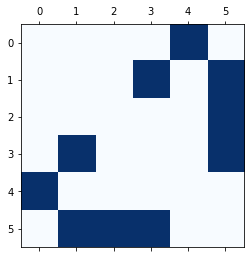

In [7]:
# Target graph
plt.matshow(simulated_data.G, cmap='Blues')

### Generating Initial Data

These are used as our initial guess for Sigma, K, B, Theta and G

In [8]:
# # Initial guesses
initial = Simulator(D, V, M, k, gamma, 2020)
initial.sample_GK()
initial.sample_B()
initial.sample_H()

Success: Sigma transformed from K
Success: G transformed from K


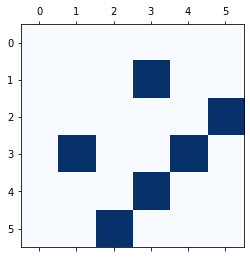

In [9]:
# Initial graph
plt.matshow(initial.G, cmap='Blues')

## Global Sampler

All objects are updated within the cycle.

In [ ]:
%%time
max_iterations = 5000
np.random.seed(25041945)

# Initialization
Sigma = initial.Sigma.copy()
K = np.linalg.inv(Sigma)
B = initial.B.copy()
Theta = initial.Theta.copy()
G = initial.G.copy()

alpha = np.ones(V)  # Uninformative prior
b = k - 1

Z = sample_Z_from_W(simulated_data.W.astype(int), k, 2020)  # Random sample of Z based on actual data

E = update_E(np.zeros((D, k)), Z)  # Transformation of Z
C = update_C(np.zeros((k, V)), Z)  # Transformation of Z

H = None
step = 0.5

# Metrics

Zerrors = []

Berrors = []
B_converge = [] 

waiting_times = []
sampled_Gs = []
graph_changes = []
edges_log = []
errors_log = []


for iteration in range(max_iterations):
    
    # Step 1
    Z, E, C = MC_sample_Z(Z, simulated_data.W, Theta, B, E, C, debug=True)
    Zerrors.append(binder_loss(Z, simulated_data.Z))
    
    # Step 2
    last_B = B.copy()
    B = MC_sample_B(alpha, C)
    B_converge.append(np.linalg.norm(B - last_B))
    
    err_by_it = []
    for topic in range(k):
        err_by_it.append(np.linalg.norm(B[topic] - last_B[topic]))  # Computing error wrt the target distribution  # BUG https://trello.com/c/uEYV7fSC/32-mcsampleb-shape-mismatch
    Berrors.append(err_by_it)
    
    # Step 3
    H, step = MC_sample_H(E, Sigma, K, step_size=step, H_current=H, burn_in=15)
    Theta = update_Theta(Theta, H)  # get Theta from H
    
    # Step 4    
    G_old = G.copy()
    wt_sample, G_new, K = MC_sample_GK(G, H, b, debug=False)
    
    graph_changes.append(~np.all(G_new == G_old))
    
    G = G_new
    Sigma = np.linalg.inv(K)
    
    waiting_times.append(wt_sample)
    sampled_Gs.append(G.copy())
    
    wrong_edges = np.sum(G != simulated_data.G)
    error = np.linalg.norm(Sigma - simulated_data.Sigma)
    edges_log.append(wrong_edges)
    errors_log.append(error)
    
    if iteration%500==0:
        print('Now at iteration '+str(iteration)+'/'+str(max_iterations))
    
# NOTE: Should perform 500 iterations every 7 minutes
# If it takes longer, RESTART, it could have gotten stuck in the R part

In [ ]:
errors = pd.Series(Zerrors)
print("Z binder loss metrics")
print(errors.describe())
errors.hist(bins=30)
plt.suptitle('Z binder loss histogram', x=0.5, y=1, ha='center')
plt.show()

errors.plot(title="Z convergence series")  # See if we still have a caterpillar
plt.show()

errors[0:200].plot(title="Z convergence series: First 200 iterations")
plt.show()

errors[cut:].plot(title="Z convergence series: Last iterations")
plt.show()

B convergence metrics
count    4000.000000
mean        0.260634
std         0.048675
min         0.126901
25%         0.228721
50%         0.259398
75%         0.290657
max         0.518723
dtype: float64


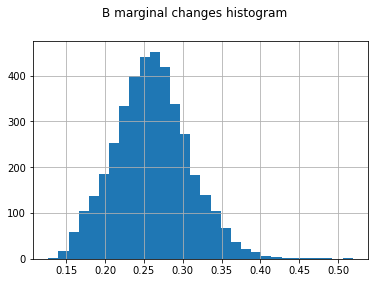

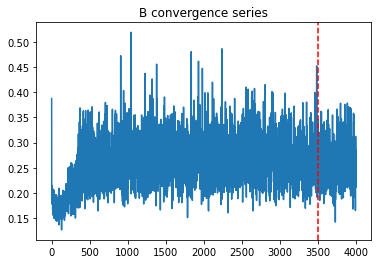

In [16]:
B_conv = pd.Series(B_converge)

print("B convergence metrics")
print(B_conv.describe())

B_conv.hist(bins=30)  # Should look like an exponential decay?
plt.suptitle('B marginal changes histogram', x=0.5, y=1, ha='center')
plt.show()

B_conv.plot(title="B convergence series")  # Find where it stabilizes
# TODO: Add the finder for a certain threshold and plot the vertical line of the iteration and save variable
cut = 3500
plt.axvline(x=cut, color='red', linestyle='--')
plt.show()

B_conv[0:200].plot(title="B convergence series: First 200 iterations")
plt.show()

B_conv[cut:].plot(title="B convergence series: Last iterations")
plt.show()

In [ ]:
Berrors = pd.DataFrame(Berrors)
print("B L2-error metrics")
print(errors.describe())

Berrors.hist(bins=30, layout=(3,2), figsize=(10, 6))
plt.show()

Berrors.plot(subplots=True, layout=(3,2), figsize=(10, 6))
plt.title('B L2-error series')
plt.axvline(x=cut, color='red', linestyle='--')
plt.show()

Berrors[0:200].plot(subplots=True, layout=(3,2), figsize=(10, 6))
plt.title('B L2-error series: First 200 iterations')
plt.show()

Berrors[cut:].plot(subplots=True, layout=(3,2), figsize=(10, 6))
plt.title('B L2-error series: Last iterations')
plt.show()

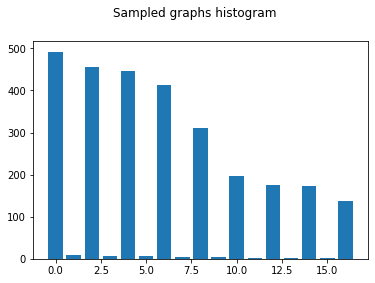

In [25]:
graphs = []
counts = []
not_found = True
for graph in sampled_Gs[cut:]:
    for i in range(len(graphs)):
        not_found = True
        if np.all(graph == graphs[i]):
            counts[i] += waiting_times[i]
            not_found = False
    if not_found:
        graphs.append(graph)
        counts.append(waiting_times[i])

plt.bar(range(len(counts)),counts)
plt.suptitle('Sampled graphs histogram', x=0.5, y=1, ha='center')
plt.show()

modes = counts.sort()

plt.matshow(graphs[counts.index(modes[0])], cmap='Blues')
plt.suptitle("Most frequent graph in stable region", x=0.5, y=1, ha='center')
plt.show()

plt.matshow(graphs[counts.index(modes[1])], cmap='Blues')
plt.suptitle("Second most frequent graph in stable region", x=0.5, y=1, ha='center')
plt.show()

plt.matshow(graphs[counts.index(modes[2])], cmap='Blues')
plt.suptitle("Third most frequent graph in stable region", x=0.5, y=1, ha='center')
plt.show()

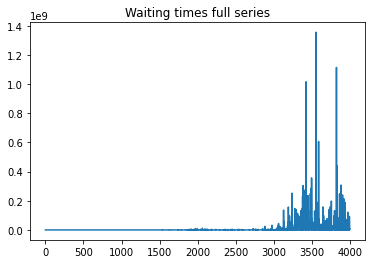

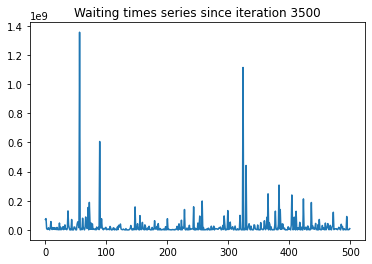

In [18]:
wait_times_full = pd.Series(waiting_times)
wait_times_full.plot(title="Waiting times full series")
plt.show()

wait_times_cut = pd.Series(waiting_times[cut:])
wait_times_cut.plot(title="Waiting times series since iteration "+str(cut))
plt.show()

#### Data dumping

In [ ]:
from datetime import datetime as dt
import pickle

In [ ]:
timestamp = dt.now().strftime("%Y-%m-%d_%H%M")  # by minute

filename = 'Zerrors.pkl'
with open(timestamp + '_' + filename, 'wb+') as f:  # opens a (new) file in write byte mode 
    pickle.dump(Zerrors, f)

filename = 'Berrors.pkl'
with open(timestamp + '_' + filename, 'wb+') as f:  # opens a (new) file in write byte mode 
    pickle.dump(Berrors, f)

filename = 'B_converge.pkl'
with open(timestamp + '_' + filename, 'wb+') as f:  # opens a (new) file in write byte mode 
    pickle.dump(B_converge, f)
    
filename = 'waiting_times.pkl'
with open(timestamp + '_' + filename, 'wb+') as f:  # opens a (new) file in write byte mode 
    pickle.dump(waiting_times, f)
    
filename = 'sampled_Gs.pkl'
with open(timestamp + '_' + filename, 'wb+') as f:  # opens a (new) file in write byte mode 
    pickle.dump(sampled_Gs, f)
    
filename = 'graph_changes.pkl'
with open(timestamp + '_' + filename, 'wb+') as f:  # opens a (new) file in write byte mode 
    pickle.dump(graph_changes, f)
    
filename = 'edges_log.pkl'
with open(timestamp + '_' + filename, 'wb+') as f:  # opens a (new) file in write byte mode 
    pickle.dump(edges_log, f)
    
filename = 'errors_log.pkl'
with open(timestamp + '_' + filename, 'wb+') as f:  # opens a (new) file in write byte mode 
    pickle.dump(errors_log, f)

In [ ]:
with open(timestamp + '_' + filename, 'rb') as f:  # opens a file in read byte mode 
    my_saved_results = pickle.load(f)

### Generating Uninformative Initial Data

These are used as our initial guess for Sigma, K, B, Theta and G

In [ ]:
# Initial guesses
initial_uninf = Simulator(D, V, M, k, gamma, 2020)
initial_uninf.generate_non_informative()

# Initial graph
plt.matshow(initial_uninf.G, cmap='Blues')

## Global Sampler

All objects are updated within the cycle.

In [ ]:
%%time
max_iterations = 5000
np.random.seed(25041945)

# Initialization
Sigma1 = initial.Sigma.copy()
K = np.linalg.inv(Sigma)
B = initial.B.copy()
Theta = initial.Theta.copy()
G = initial.G.copy()

alpha = np.ones(V)  # Uninformative prior
b = k - 1

Z = sample_Z_from_W(simulated_data.W.astype(int), k, 2020)  # Random sample of Z based on actual data

E = update_E(np.zeros((D, k)), Z)  # Transformation of Z
C = update_C(np.zeros((k, V)), Z)  # Transformation of Z

H = None
step = 0.5

# Metrics

Zerrors1 = []

Berrors1 = []
B_converge1 = [] 

waiting_times1 = []
sampled_Gs1 = []
graph_changes1 = []
edges_log1 = []
errors_log1 = []


for iteration in range(max_iterations):
    
    # Step 1
    Z, E, C = MC_sample_Z(Z, simulated_data.W, Theta, B, E, C, debug=True)
    Zerrors1.append(binder_loss(Z, simulated_data.Z))
    
    # Step 2
    last_B = B.copy()
    B = MC_sample_B(alpha, C)
    B_converge1.append(np.linalg.norm(B - last_B))
    
    err_by_it = []
    for topic in range(k):
        err_by_it.append(np.linalg.norm(B[topic] - last_B[topic]))  # Computing error wrt the target distribution  # BUG https://trello.com/c/uEYV7fSC/32-mcsampleb-shape-mismatch
    Berrors1.append(err_by_it)
    
    # Step 3
    H, step = MC_sample_H(E, Sigma, K, step_size=step, H_current=H, burn_in=15)
    Theta = update_Theta(Theta, H)  # get Theta from H
    
    # Step 4    
    G_old = G.copy()
    wt_sample, G_new, K = MC_sample_GK(G, H, b, debug=False)
    
    graph_changes1.append(~np.all(G_new == G_old))
    
    G = G_new
    Sigma = np.linalg.inv(K)
    
    waiting_times1.append(wt_sample)
    sampled_Gs1.append(G.copy())
    
    wrong_edges = np.sum(G != simulated_data.G)
    error = np.linalg.norm(Sigma - simulated_data.Sigma)
    edges_log1.append(wrong_edges)
    errors_log1.append(error)
    
    if iteration%500==0:
        print('Now at iteration '+str(iteration)+'/'+str(max_iterations))
    
# NOTE: Should perform 500 iterations every 7 minutes
# If it takes longer, RESTART, it could have gotten stuck in the R part

In [ ]:
errors = pd.Series(Zerrors1)
print("Z binder loss metrics")
print(errors.describe())
errors.hist(bins=30)
plt.suptitle('Z binder loss histogram', x=0.5, y=1, ha='center')
plt.show()

errors.plot(title="Z convergence series")  # See if we still have a caterpillar
plt.show()

errors[0:200].plot(title="Z convergence series: First 200 iterations")
plt.show()

errors[cut:].plot(title="Z convergence series: Last iterations")
plt.show()

In [ ]:
B_conv = pd.Series(B_converge)

print("B convergence metrics")
print(B_conv.describe())

B_conv.hist(bins=30)  # Should look like an exponential decay?
plt.suptitle('B marginal changes histogram', x=0.5, y=1, ha='center')
plt.show()

B_conv.plot(title="B convergence series")  # Find where it stabilizes
# TODO: Add the finder for a certain threshold and plot the vertical line of the iteration and save variable
cut = 3500
plt.axvline(x=cut, color='red', linestyle='--')
plt.show()

B_conv[0:200].plot(title="B convergence series: First 200 iterations")
plt.show()

B_conv[cut:].plot(title="B convergence series: Last iterations")
plt.show()

In [ ]:
Berrors = pd.DataFrame(Berrors)
print("B L2-error metrics")
print(errors.describe())

Berrors.hist(bins=30, layout=(3,2), figsize=(10, 6))
plt.show()

Berrors.plot(subplots=True, layout=(3,2), figsize=(10, 6))
plt.title('B L2-error series')
plt.axvline(x=cut, color='red', linestyle='--')
plt.show()

Berrors[0:200].plot(subplots=True, layout=(3,2), figsize=(10, 6))
plt.title('B L2-error series: First 200 iterations')
plt.show()

Berrors[cut:].plot(subplots=True, layout=(3,2), figsize=(10, 6))
plt.title('B L2-error series: Last iterations')
plt.show()

In [ ]:
graphs = []
counts = []
not_found = True
for graph in sampled_Gs[cut:]:
    for i in range(len(graphs)):
        not_found = True
        if np.all(graph == graphs[i]):
            counts[i] += waiting_times[i]
            not_found = False
    if not_found:
        graphs.append(graph)
        counts.append(waiting_times[i])

plt.bar(range(len(counts)),counts)
plt.suptitle('Sampled graphs histogram', x=0.5, y=1, ha='center')
plt.show()

modes = counts.sort()

plt.matshow(graphs[counts.index(modes[0])], cmap='Blues')
plt.suptitle("Most frequent graph in stable region", x=0.5, y=1, ha='center')
plt.show()

plt.matshow(graphs[counts.index(modes[1])], cmap='Blues')
plt.suptitle("Second most frequent graph in stable region", x=0.5, y=1, ha='center')
plt.show()

plt.matshow(graphs[counts.index(modes[2])], cmap='Blues')
plt.suptitle("Third most frequent graph in stable region", x=0.5, y=1, ha='center')
plt.show()

In [ ]:
wait_times_full = pd.Series(waiting_times)
wait_times_full.plot(title="Waiting times full series")
plt.show()

wait_times_cut = pd.Series(waiting_times[cut:])
wait_times_cut.plot(title="Waiting times series since iteration "+str(cut))
plt.show()

#### Data dumping

In [ ]:
from datetime import datetime as dt
import pickle

In [ ]:
timestamp = dt.now().strftime("%Y-%m-%d_%H%M")  # by minute

filename = 'Zerrors.pkl'
with open(timestamp + '_' + filename, 'wb+') as f:  # opens a (new) file in write byte mode 
    pickle.dump(Zerrors, f)

filename = 'Berrors.pkl'
with open(timestamp + '_' + filename, 'wb+') as f:  # opens a (new) file in write byte mode 
    pickle.dump(Berrors, f)

filename = 'B_converge.pkl'
with open(timestamp + '_' + filename, 'wb+') as f:  # opens a (new) file in write byte mode 
    pickle.dump(B_converge, f)
    
filename = 'waiting_times.pkl'
with open(timestamp + '_' + filename, 'wb+') as f:  # opens a (new) file in write byte mode 
    pickle.dump(waiting_times, f)
    
filename = 'sampled_Gs.pkl'
with open(timestamp + '_' + filename, 'wb+') as f:  # opens a (new) file in write byte mode 
    pickle.dump(sampled_Gs, f)
    
filename = 'graph_changes.pkl'
with open(timestamp + '_' + filename, 'wb+') as f:  # opens a (new) file in write byte mode 
    pickle.dump(graph_changes, f)
    
filename = 'edges_log.pkl'
with open(timestamp + '_' + filename, 'wb+') as f:  # opens a (new) file in write byte mode 
    pickle.dump(edges_log, f)
    
filename = 'errors_log.pkl'
with open(timestamp + '_' + filename, 'wb+') as f:  # opens a (new) file in write byte mode 
    pickle.dump(errors_log, f)

In [ ]:
with open(timestamp + '_' + filename, 'rb') as f:  # opens a file in read byte mode 
    my_saved_results = pickle.load(f)